In [1]:
import os
import sys
import re
import matplotlib

import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns
import matplotlib.colors as colors

from scipy.stats     import rankdata
from matplotlib      import cm
from sklearn.metrics import mean_squared_error
from functools       import reduce

sys.path.append('../../docs/')

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype']  = 42

pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 1000)

# Setting the configurations for data processing

In [2]:
groundtruth_method   = 'SHAP' #['SHAP', 'gradient']
representative       = np.mean  # function to evaluate over the 30 executions per dataset (i.g np.mean, np.median)
explainers           = ['PE', 'PE_adj', 'SHAP', 'SHAP_adj', 'LIME', 'GINI']  # we'll try to retrieve data from the explainers listed
reps                 = 30
normalization_method = 'ExErr' #['ExErr', 'None', 'AbsMax']

# Inspecting the data sets

,Filename,Number,Output,Formula,# variables,v1_name,v1_low,v1_high,v2_name,v2_low,v2_high,v3_name,v3_low,v3_high,v4_name,v4_low,v4_high,v5_name,v5_low,v5_high,v6_name,v6_low,v6_high,v7_name,v7_low,v7_high,v8_name,v8_low,v8_high,v9_name,v9_low,v9_high,v10_name,v10_low,v10_high
0,I.6.2a,1,f,exp(-theta**2/2)/sqrt(2*pi),1,theta,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,I.6.2,2,f,exp(-(theta/sigma)**2/2)/(sqrt(2*pi)*sigma),2,sigma,1,3,theta,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,I.6.2b,3,f,exp(-((theta-theta1)/sigma)**2/2)/(sqrt(2*pi)*sigma),3,sigma,1,3,theta,1.0,3.0,theta1,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,I.8.14,4,d,sqrt((x2-x1)**2+(y2-y1)**2),4,x1,1,5,x2,1.0,5.0,y1,1.0,5.0,y2,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,I.9.18,5,F,G*m1*m2/((x2-x1)**2+(y2-y1)**2+(z2-z1)**2),9,m1,1,2,m2,1.0,2.0,G,1.0,2.0,x1,3.0,4.0,x2,1.0,2.0,y1,3.0,4.0,y2,1.0,2.0,z1,3.0,4.0,z2,1.0,2.0,NaN,NaN,NaN


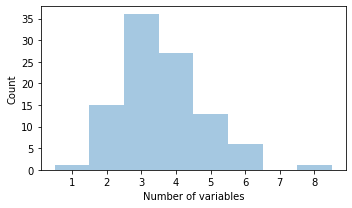

In [3]:
global_groundtruth_data = pd.read_csv(f'../../results/ground_truth/{groundtruth_method}_groundtruth-globalexplanations.csv')
local_groundtruth_data  = pd.read_csv(f'../../results/ground_truth/{groundtruth_method}_groundtruth-localexplanations.csv')

feynman_info = pd.read_csv('../../docs/FeynmanEquations.csv')

display(feynman_info.head())

# Plotting the distribution of the number of variables
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

ax = sns.distplot(feynman_info['# variables'], ax=ax, bins=np.arange(feynman_info['# variables'].min() - 0.5, feynman_info['# variables'].max()+ 0.5, 1), kde=False)

ax.set_xlabel('Number of variables')
ax.set_ylabel('Count')

plt.tight_layout()
plt.savefig('../../results/figures/numofvariables.pdf')
plt.show()

# Method for processing all global and local data for a generic combination of explainer-regressor

In [4]:
# importances should be a matrix
normalization = {
    'ExErr'  : lambda importances: rankdata(np.abs(importances).max() - np.abs(importances), axis=1),
    'None'   : lambda importances: np.abs(importances),
    'AbsMax' : lambda importances: np.abs(importances)/np.abs(importances).max(axis=1)[:, None],
}


# parses the importances information on a matrix
def importances_matrix(dataframe_slice):
        
    return np.array([np.fromstring(dataframe_slice[f'ImportanceObs{i}'].values[0][1:-1], dtype=np.float64, sep=' ')
        for i in range(100)])


# Creating a dataset object for the regressor
def preprocess_data(regressor, regressorAcronym):
    global_data    = pd.read_csv(f'../../results/tabular_raw/{regressor}-globalexplanations.csv')
    local_data     = pd.read_csv(f'../../results/tabular_raw/{regressor}-localexplanations.csv')
    regressor_data = pd.read_csv(f'../../results/tabular_raw/{regressor}-regressionresults.csv')
    
    # Columns will have the mean or median
    columns = [
        'Dataset', # Dataset will be the primary key to merge the processed informations
        
        f'RMSE-train-{regressorAcronym}',
        f'RMSE-test-{regressorAcronym}',
        f'Tottime-train-{regressorAcronym}'
    ] + [
        f'{scope}-{explainer}-{regressorAcronym}'
        for explainer in explainers
        for scope in ['Global', 'Local']
    ]
    processed_data  = {c:[] for c in columns}
        
    # Finding only datasets with results reported
    datasets = set(global_data['Dataset'].tolist() + local_data['Dataset'].tolist())
    
    # now we'll iterate through the dataset
    for ds in sorted(datasets):

        # Slicing the dataset for practicity
        global_slice    = global_data[global_data['Dataset'] == ds]
        local_slice     = local_data[local_data['Dataset'] == ds]
        feynman_slice   = feynman_info[feynman_info['Filename'] == ds]
        regressor_slice = regressor_data[regressor_data['Dataset'] == ds]

        # friendly warning that some results are missing (still be doing the processing though)
        if regressor_slice.shape[0] < reps: 
            print(f'Dataset {ds} does not contain {reps} results.')

        processed_data['Dataset'].append(ds)
        
        for info in ['RMSE-train', 'RMSE-test', 'Tottime-train']:
            processed_data[f'{info}-{regressorAcronym}'].append(
                representative(regressor_slice[f'{info}-{regressorAcronym}']))
                
        # getting the ground truth (they will be two matrices)
        global_groundtruth_slice = normalization[normalization_method](importances_matrix(global_groundtruth_data[global_groundtruth_data['Dataset']==ds]))
        local_groundtruth_slice  = normalization[normalization_method](importances_matrix(local_groundtruth_data[local_groundtruth_data['Dataset']==ds]))
            
        # Trying to get results for each applicable explainer
        for explainer in explainers:
            global_errors = []
            local_errors  = []
        
            # Trying to get all executions to use the representative function
            for i in range(reps):
                try:
                    # loading importances for the execution number i               
                    global_importances = normalization[normalization_method](importances_matrix(global_slice[
                        (global_slice['Dataset']==ds) &
                        (global_slice['Rep']==i) &
                        (global_slice['Explainer']==f'Global-{explainer}-{regressorAcronym}')
                    ]))

                    local_importances = normalization[normalization_method](importances_matrix(local_slice[
                        (local_slice['Dataset']==ds) &
                        (local_slice['Rep']==i) &
                        (local_slice['Explainer']==f'Local-{explainer}-{regressorAcronym}')
                    ]))

                    # Global: error of the mean
                    global_errors.append(mean_squared_error(
                        np.mean(global_groundtruth_slice, axis=0), 
                        np.mean(global_importances, axis=0),
                    squared=False))

                    # Local: mean of the errors
                    local_errors.append(np.mean([
                        mean_squared_error(
                            local_groundtruth_slice[i, :],
                            local_importances[i, :], 
                            squared=False)
                        for i in range(100)]
                    ))
                except Exception as e:
                    continue
        
            # If we have results to use:
            if len(global_errors) > 0:
                processed_data[f'Global-{explainer}-{regressorAcronym}'].append(representative(global_errors))
            else:
                processed_data[f'Global-{explainer}-{regressorAcronym}'].append(np.nan)
            
            if len(local_errors) > 0:
                processed_data[f'Local-{explainer}-{regressorAcronym}'].append(representative(local_errors))
            else:
                processed_data[f'Local-{explainer}-{regressorAcronym}'].append(np.nan)
                
    return pd.DataFrame(processed_data)

# Processing information for individual regressors

In [5]:
itea_processed = preprocess_data('itea', 'ITEA').set_index('Dataset').sort_index(axis=1).dropna(axis=1)

In [6]:
xgb_processed  = preprocess_data('xgradboost', 'XGB').set_index('Dataset').sort_index(axis=1).dropna(axis=1)

In [7]:
rf_processed   = preprocess_data('randomforest', 'RF').set_index('Dataset').sort_index(axis=1).dropna(axis=1)

In [8]:
kr_processed   = preprocess_data('kernelridge', 'KR').set_index('Dataset').sort_index(axis=1).dropna(axis=1)

# Merging and saving all explanations

In [9]:
# Merging
df_merged = reduce(
    lambda left, right: pd.merge(left,right,on=['Dataset'], how='inner'),
    [itea_processed, rf_processed, xgb_processed, kr_processed]
).sort_index(axis=1)

# Saving csv file
df_merged.to_csv(
    f'../../results/tabular_processed/processed_results-{groundtruth_method}-{normalization_method}.csv', sep=',', header=True)

# Creating a table with three different heatmaps between columns. 
# The heatmaps are created individually for each row. It represents
# the average performance of each combination of explainer-regressor
# for each data set.
df_styled = (df_merged[[c for c in df_merged.columns if 'Global' in c or 'Local' in c or 'RMSE-test' in c]].style
    .background_gradient(
        cmap=cm.get_cmap('bone'), axis=1,
        subset=[c for c in df_merged.columns if 'Global' in c]
    )
    .background_gradient(
        cmap=cm.get_cmap('copper'), axis=1,
        subset=[c for c in df_merged.columns if 'Local' in c]
    )
    .background_gradient(
        cmap=cm.get_cmap('pink'), axis=1,
        subset=[c for c in df_merged.columns if 'RMSE-test' in c]
    )
)
    
# exporting colored table to excel
df_styled.to_excel(
        f'../../results/tabular_processed/processed_results-{groundtruth_method}-{normalization_method}.xlsx', header=True)
    
# Displaying the table that was exported
display(df_styled) 